Going to get shapefiles of lakes which contain WA Ecology data. 

In [23]:
import argparse

In [12]:
import geopandas as gpd
import pandas as pd
from fuzzywuzzy import process
from shapely.geometry import Point
import folium
from folium.plugins import MarkerCluster

%matplotlib inline

In [13]:
lakesfile = "/Volumes/wrangell-st-elias/research/wa-shapefiles/Shape/NHDWaterbody.shp"
codesdbfile = "/Volumes/wrangell-st-elias/research/wa-shapefiles/Shape/NHDFCode.dbf"
ecologydata = "../waeco/phytoplankton2017_11_6.csv"
locations = "../waeco/EIMLocation.csv"

In [14]:
nhdLakes = gpd.read_file(lakesfile)
nhdLakes.head()

OSError: no such file or directory: '/Volumes/wrangell-st-elias/research/wa-shapefiles/Shape/NHDWaterbody.shp'

In [15]:
ecodata = pd.read_csv(ecologydata)
print(len(ecodata))
ecodata = ecodata.dropna(axis=0) # need sites with location data
print(len(ecodata))


19813
19567


In [17]:
ecolocations = pd.read_csv(locations)

In [18]:
ecolocations.head()

,Location_ID,Location_Name,Location_Setting,Location_Description,County,Coordinate_System,Latitude_Decimal_Degrees,Longitude_Decimal_Degrees,Horizontal_Coordinates_Represent,Horizontal_Datum,Horizontal_Coordinate_Accuracy,Horizontal_Coordinate_Collection_Method,Paper_Map_Scale
0,020Ki,"Hidden Lake Beach, King",Lake/Pond/Reservoir,"Hidden Lake Beach, King",King,LAT/LONG,47.752182,-122.369980,99,1,99,13,1
1,060Ki,"Idylwood Beach, King",Lake/Pond/Reservoir,"Idylwood Beach, King",King,LAT/LONG,47.641644,-122.099823,99,1,99,13,1
2,061Ki,"Lake Sammamish Beach, King",Lake/Pond/Reservoir,"Lake Sammamish Beach, King",King,LAT/LONG,47.556844,-122.070323,99,1,99,13,1
3,080Ki,"Juanita Beach, King",Lake/Pond/Reservoir,"Juanita Beach, King",King,LAT/LONG,47.704210,-122.214630,99,1,99,13,1
4,080Ki,"Log Boom Park (Lake Washington), King",Lake/Pond/Reservoir,"Log Boom Park (Lake Washington), King",King,LAT/LONG,47.757667,-122.264293,99,1,99,13,1


In [19]:
site_loc_indices = dict(zip(set(ecodata.Site),
                            list(map(lambda x: process.extractOne(x, ecolocations.Location_Name)[2],
                                     set(ecodata.Site)))))

In [20]:
ecolocation_idx_col = ecodata.Site.map(lambda x: site_loc_indices[x])

In [21]:
ecodata['loc_idx'] = ecolocation_idx_col

In [22]:
ecodataMerged = ecodata.merge(ecolocations[['Latitude_Decimal_Degrees', 'Longitude_Decimal_Degrees']], how='left', left_on='loc_idx', right_index=True)
ecodataMerged.head()

,County,WRIA Number,Site,Lab Sample Number,Collect Date,Parameter,Dominance,loc_idx,Latitude_Decimal_Degrees,Longitude_Decimal_Degrees
94,Benton,37.0,Yakima Delta,L68576-2,09/06/2017,Achnanthes sp.,Present,300,46.23886,-119.22881
95,Benton,37.0,Yakima Delta,L68576-2,09/06/2017,Actinastrum sp.,Present,300,46.23886,-119.22881
96,Benton,37.0,Yakima Delta,L68576-2,09/06/2017,Amphora sp.,Present,300,46.23886,-119.22881
97,Benton,37.0,Yakima Delta,L68576-2,09/06/2017,Anabaena: trichome irregularly twisted,Present,300,46.23886,-119.22881
98,Benton,37.0,Yakima Delta,L68576-2,09/06/2017,Ankistrodesmus sp.,Present,300,46.23886,-119.22881


In [14]:
geometry = [Point(xy) for xy in zip(ecodataMerged.Longitude_Decimal_Degrees, ecodataMerged.Latitude_Decimal_Degrees)]
ecodataMerged = ecodataMerged.drop(['Latitude_Decimal_Degrees', "Longitude_Decimal_Degrees"], axis=1)
crs = {"init" : 'epsg:4326'}
ecodataMerged = gpd.GeoDataFrame(ecodataMerged, crs=crs, geometry=geometry)

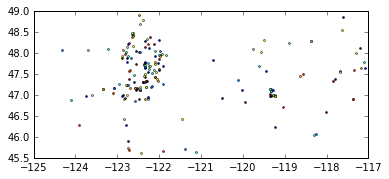

In [15]:
ecodataMerged.drop_duplicates(subset='Site').plot()

In [16]:
ecodataMerged.to_csv('../waeco/phytoplankton2017_11_6_with_locations.csv')

---
ok, now let's get those lake shapefiles with data in them. 

In [17]:

fcodes = gpd.read_file(codesdbfile)

In [52]:
lakes = nhdLakes
lakesCoded = pd.merge(lakes,
                      fcodes.drop('geometry', axis=1), 
                      left_on='FCODE', right_on='FCODE',
                      how='left')
biglakes = lakesCoded[(lakesCoded.HYDROGRAPH == 'Perennial') & (lakesCoded.AREASQKM > 0.1) & (lakesCoded.AREASQKM < 20)]
m = folium.Map([47.59, -120.3], zoom_start=8)
folium.GeoJson(biglakes.to_json(), name='biglakes', control=True).add_to(m)
singlesites = ecodataMerged.drop_duplicates(subset='Site')
coords=[]
popups=[]
for i, row in ecodataMerged.iterrows():
    #Append lat and long coordinates to "coords" list
    coords.append([row.geometry.y, row.geometry.x])
    #Create a string of HTML code used in the IFrame popup
    #Join together the fields in "popup_field_list" with a linebreak between them
    label = row.Site
    #Append an IFrame that uses the HTML string to the "popups" list 

[folium.Marker(location=x).add_to(m) for x in coords]

m.save("lakes-points.html")


KeyboardInterrupt: 

In [58]:
m = folium.Map([47.59, -120.3], zoom_start=8)
singlesites = ecodataMerged.drop_duplicates(subset='Site')
markers = [folium.Marker(location=[row.geometry.y, row.geometry.x]).add_to(m) for idx, row in singlesites.iterrows()]
m.save('stations.html')

In [65]:
import cartopy.crs as ccrs
import cartopy.feature as feature
from cartopy.feature import NaturalEarthFeature
import matplotlib.pyplot as plt

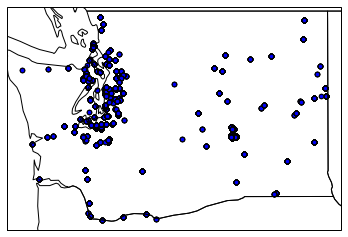

In [93]:
ax = plt.axes(projection=ccrs.Mercator().GOOGLE)
states = NaturalEarthFeature(category='cultural', scale='50m', facecolor='none', name='admin_1_states_provinces_shp')
ax.add_feature(states)
y, x = zip(*coords)
ax.scatter(x, y, transform=ccrs.PlateCarree())


In [86]:
singlesites.geometry[94].x

-119.22881000000001